# 3.1: Path Planning 
Start Node: (row, column, direction) <br>
N: 0 <br>
E: 90 <br>
S: 180 <br>
W: 270 <br>



In [1]:
# Start/End position 

start_row = 2
start_column = 4
start_dir = 0 # N
end_row = 5
end_column = 8


In [2]:
import cv2
import numpy as np
import random
import math
from matplotlib import pyplot as plt


## Helper Functions

In [3]:
def path_clear(image, x1, y1, x2, y2):
    x1 = int(x1)
    x2 = int(x2)
    y1 = int(y1)
    y2 = int(y2)

    x_lower = min(x1,x2)
    x_higher = max(x1,x2)
    
    y_lower = min(y1,y2)
    y_higher = max(y1,y2)
    
    white_pixel = [255, 255, 255]
    
    # SPECIAL: Vertical case
    if (x1==x2):
        for y in range(y_lower,y_higher):
            if not (image[y, x1] == white_pixel).all():
                return False
    # SPECIAL: Horizontal case
    elif (y1==y2):
        for x in range(x_lower,x_higher):
            if not (image[y1, x] == white_pixel).all():
                return False  
        
    # All other cases
    else:
        m = (y2-y1)/(x2-x1)
        b = -m*x1+y1
        for x in range(x_lower,x_higher):
            y = math.ceil(m*x+b)
            if not (image[y, x] == white_pixel).all():
                return False
        
    return True

In [4]:
# Rotate image for processing

def rotateImage(image, angle):
    row,col,_ = image.shape
    center=tuple(np.array([row,col])/2)
    rot_mat = cv2.getRotationMatrix2D(center,angle,1.0)
    new_image = cv2.warpAffine(image, rot_mat, (col,row))
    return new_image

## Main Code

### Convert Image to map

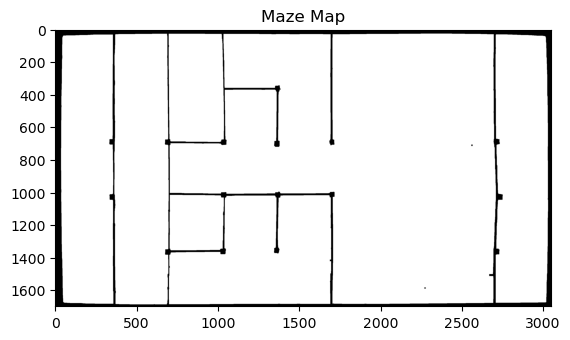

In [5]:
IMAGE_FILE = "maze.png"
image = cv2.imread(IMAGE_FILE)

# Crop image
image = image[250:1950,400:3450]
image = rotateImage(image,0.5)

# Convert the image from BGR to HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the range for the maze walls in HSV
# lower_hsv = np.array([0, 1, 45])
# lower_hsv = np.array([0, 2, 60])
lower_hsv = np.array([0, 1, 55])
upper_hsv = np.array([83, 255, 255])

# Create a mask for the maze walls
mask = cv2.inRange(hsv_image, lower_hsv, upper_hsv)

# Create the kernel for erosion and dilation
kernel = np.ones((7, 7), np.uint8)

# Perform the erosion/dialation operation
eroded_mask = cv2.erode(mask, kernel, iterations=10)
dilated_mask = cv2.dilate(eroded_mask, kernel, iterations=9)

# Make everything but the walls white
map_image = np.ones_like(image) * 255
map_image[dilated_mask == 0] = [0,0,0]

# Display result
plt.title("Maze Map")
plt.imshow(map_image)
plt.show()



### Render Unsafe Area

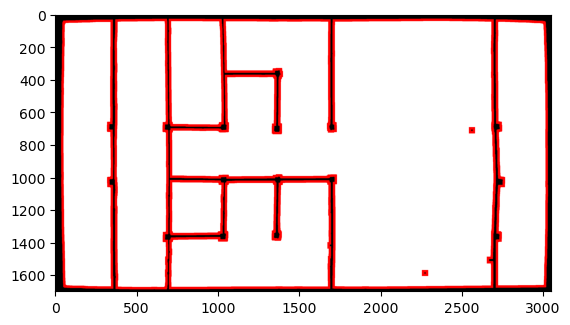

In [6]:
# kernel = np.ones((unsafe_kernel_size, unsafe_kernel_size), np.uint8) # TODO: Use this kernenl to generate un_safe area
img_unsafe = cv2.erode(map_image,kernel, iterations = 5)
# plt.imshow(img_unsafe)

img_dif = cv2.subtract(map_image,img_unsafe)
# plt.imshow(img_dif)
buffer_mask = np.all(img_dif == [255,255,255], axis=-1)
map_image[buffer_mask]=[255,0,0]
# plt.imshow(map_image)
img_dangerzone = map_image.copy()
plt.imshow(img_dangerzone)

# Display resulting image
plt.show()


### Graph class

In [7]:
# Class
class Node:
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y
    
    def get_point(self):
        return (self.x,self.y)
    
    def get_ID(self):
        return self.id

class Graph:
    def __init__(self):
        self.nodes = {}
        self.edges = {}

    def add_node(self, node_id, x, y):
        # Only make node if node does not exist
        node_list = self.nodes
        if node_id not in node_list:
            new_node = Node(node_id,x,y)
            node_list[node_id] = new_node
            # create empty dictionary to store node for other side of the edge 
            self.edges[node_id] = {}
        pass
    def check_edge_exists(self,node_id1,node_id2):
        edge_list = self.edges
        if node_id1 in edge_list and node_id2 in edge_list:
            if node_id2 in edge_list[node_id1]:
                return True
            else:
                return False
        else:
            return False

    def add_edge(self, node_id1, node_id2, weight):
        node_list = self.nodes
        edge_list = self.edges
        # Check if nodes exist
        nodes_exist = node_id1 in node_list and node_id2 in node_list
        edge_exists = self.check_edge_exists(node_id1,node_id2)
        if nodes_exist and not edge_exists:
            edge_list[node_id1][node_id2] = weight
            edge_list[node_id2][node_id1] = weight
        pass
     
    def remove_edge(self, node_id1, node_id2):
        edge_list = self.edges
        edge_exists = self.check_edge_exists(node_id1,node_id2)
        # Check if edge exists
        if edge_exists:
            edge_list [node_id1][node_id2] = None
            edge_list [node_id2][node_id1] = None
        pass
    
    def get_nodes(self):
        return list(self.nodes.keys())
    
    def get_edge_weight(self, node_id1, node_id2):
        edge_list = self.edges
        edge_exists = self.check_edge_exists(node_id1,node_id2)
        if edge_exists:
            edge_weight = edge_list[node_id1][node_id2]
            return edge_weight
        return None

### Create path grid

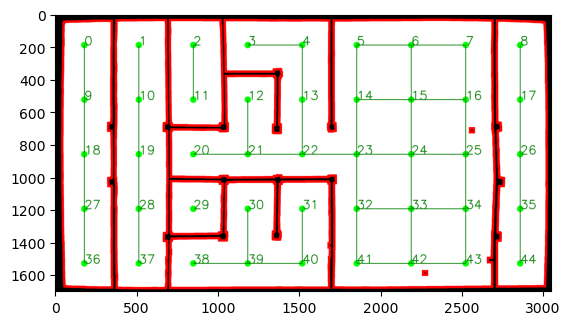

In [8]:
# Task 3.1 (4 marks): Generate a grid of nodes and connect the edges
#bfs_image = cv2.imread(image_file)
bfs_image = img_dangerzone.copy()
bfs_graph = Graph()
height, width,_ = img_dangerzone.shape
nrows = 5
ncolumns = 9
x_space = 335
y_space = 335

# Generate nodes
x = 180
y = 190
node_list = bfs_graph.nodes
for id in range(0,(nrows*ncolumns)):
    bfs_graph.add_node(id,x,y)
    if ((x+x_space)>= (width-1)):
        x = 180
        y += y_space
    else:
        x += x_space
# Generate edges
# Neighboring nodes are: node+1, node-1, node-n, node+n
# Check node exists in node list
    # If node exists, check path is clear between given nodes
row = 1
edge_list = bfs_graph.edges
for node in range(0,(nrows*ncolumns)):
    node_this = node_list[node]
    if ((node+1) in node_list) and ((node+1) % ncolumns != 0):
        if path_clear(img_dangerzone,node_this.x,node_this.y,node_list[node+1].x,node_list[node+1].y):
            bfs_graph.add_edge(node,node+1,1)
    if ((node-1) in node_list) and ((node) % ncolumns != 0):
        if path_clear(img_dangerzone,node_this.x,node_this.y,node_list[node-1].x,node_list[node-1].y):
            bfs_graph.add_edge(node,node-1,1)
    if ((node+ncolumns) in node_list):
        if path_clear(img_dangerzone,node_this.x,node_this.y,node_list[node+ncolumns].x,node_list[node+ncolumns].y):
            bfs_graph.add_edge(node,node+ncolumns,1)
    if ((node-ncolumns) in node_list):
        if path_clear(img_dangerzone,node_this.x,node_this.y,node_list[node-ncolumns].x,node_list[node-ncolumns].y):
            bfs_graph.add_edge(node,node-ncolumns,1)
# Draw Graph
# Draw Nodes
for node in range(0,(nrows*ncolumns)):
    x = int(node_list[node].x)
    y = int(node_list[node].y)
    cv2.circle(bfs_image,(x,y), 20, (0,255,0), -1)
# Draw Edges
num_edges = 104
edge_list = bfs_graph.edges
for node1 in range (0,(nrows*ncolumns)):
    x1 = int(node_list[node1].x)
    y1 = int(node_list[node1].y)
    for node2 in edge_list[node1]:
        x2 = int(node_list[node2].x)
        y2 = int(node_list[node2].y)
        distance = math.sqrt((x2-x1)**2+(y2-y1)**2)
        if (distance < (width/ncolumns)):
            cv2.line(bfs_image,(x1,y1),(x2,y2),(0,125,0),3)
            

# Draw numbers
font = cv2.FONT_HERSHEY_SIMPLEX
node_keys = list(node_list.keys())
last_node = node_keys[-1]          

for node in node_list:
    draw_x = int(node_list[node].x)
    draw_y = int(node_list[node].y)
    cv2.putText(bfs_image,str(node),(draw_x,draw_y),font,2.5,(0,125,0),3,cv2.LINE_AA)


# Display Resulting Image
plt.imshow(bfs_image)
plt.show()

### BFS

1185 525 2525 1530
Node 20: 850 860
Node 43: 2525 1530
12 43


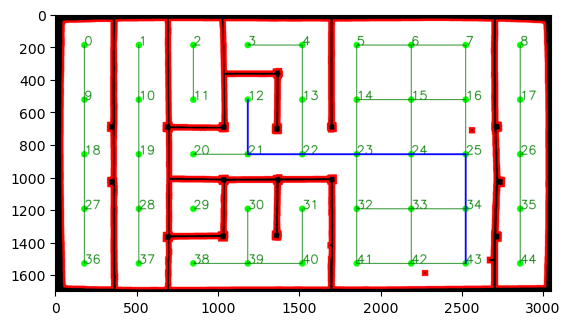

In [9]:
def bfs(graph, start_node_id, end_node_id): 
    # Initialize queue
    visited = []
    queue = [[start_node_id]]
    while queue:
        # Start path
        path = queue.pop(0)
        current_node = path[-1]
        # Found the end!
        if current_node == end_node_id:
            return path
        # If haven't been explored, explore branch
        if current_node not in visited:
            visited.append(current_node)
            edge_list = graph.edges
            adjacent_nodes = list(edge_list[current_node].keys())
            for adjacent in adjacent_nodes:
                # add new adjacent node to section of branch
                new_path = list(path)
                new_path.append(adjacent)
                queue.append(new_path)
                
    return []
# Should be node 20 to 43
# Convert start/end to node values
start_x = node_list[0].x+(start_column-1)*x_space
start_y = node_list[0].y+(start_row-1)*y_space
end_x = node_list[0].x+(end_column-1)*x_space
end_y = node_list[0].y+(end_row-1)*y_space

print(start_x,start_y,end_x,end_y)
print("Node 20:", node_list[20].x,node_list[20].y)
print("Node 43:", node_list[43].x,node_list[43].y)

for node in node_list:
    check_x = node_list[node].x
    check_y = node_list[node].y
    if (check_x == start_x and check_y == start_y):
        start_node = node
    elif (check_x == end_x and check_y == end_y):
        end_node = node

# path = bfs(bfs_graph,12,25)
# path = bfs(bfs_graph,12,7)
print(start_node,end_node)
path = bfs(bfs_graph,start_node,end_node)

# Draw path
for current in range(len(path) - 1):
    node_id1 = path[current]
    node_id2 = path[current+1]                  
    x1 = int(node_list[node_id1].x)
    y1 = int(node_list[node_id1].y)
    x2 = int(node_list[node_id2].x)
    y2 = int(node_list[node_id2].y)          
    cv2.line(bfs_image,(x1,y1),(x2,y2),(0,0,255),10)      
                          
# Display resulting image
plt.imshow(bfs_image)
plt.show()

### Robot class

In [10]:
def create_instruction(dif):
    if (dif == 0):
        return "f"
    elif (dif == 90 or dif == -270):
        return "rf"
    elif (dif == 270 or dif == -90):
        return "lf"
    elif (dif == 180 or dif == -180):
        return "rrf"

In [28]:
class bot:
    def __init__(self,x,y,b):
        self.x = x
        self.y = y
        self.b = b
        self.history = [(self.x,self.y,self.b)]

    def move(self,x,y):
        print(" -------------- starting move function ------------------")
        print("Inputs to move:",x,y)
        # assign current values of the robot
        current_x = self.x
        current_y = self.y
        current_b = self.b
        print("Current values:",current_x,current_y,current_b)
        # assign new values of the robot
        self.x = x
        self.y = y
        print("Next values:",self.x,self.y)
        # move horizontally to the right
        if ((current_y == self.y) and (self.x > current_x)):
            print ("GOING RIGHT")
            self.b = 90
        # move horizontally to the left
        elif ((current_y == self.y) and (self.x < current_x)):
            print("GOING LEFT")
            self.b = -90
        # move vertically up
        elif ((current_x == self.x) and (self.y < current_y)):
            print("GOING UP")
            self.b = 0
        # move vertically down
        elif ((current_x == self.x) and (self.y > current_y)):
            print("GOING DOWN")
            self.b = 180
        # Find change in bearing
        dif = self.b-current_b
        print("DIF",dif," = NEW:",self.b," - OLD:",current_b)

        # Add new to history
        self.history.append((self.x,self.y,self.b))
        return dif
    

### Convert path to instructions for The Boi (UNFINISHED)

In [31]:
# Create instance of bot 
start_x = node_list
boi = bot(node_list[start_node].x,node_list[start_node].y,start_dir)
instruction = ""

# Get path
print("path:",path)
# get length of standard edge
std_distance = 335

print("======================== Starting From Node",path[0], "===============================")
current_x = boi.x
current_y = boi.y
current_b = boi.b
print("Current values:",current_x,current_y,current_b)
# for node in path
for p in range(1,len(path)):
    node = path[p]
    print("======================== Going to Node",node, "===============================")
    new_x = node_list[node].x
    new_y = node_list[node].y
    print("node coordinates || ", new_x,new_y)
    bearing_dif = boi.move(new_x,new_y)
    print("bearing difference || ",bearing_dif)
    path_segment = create_instruction(bearing_dif)
    print("path segment || ", path_segment)
    instruction += path_segment
                       
print(instruction)

path: [12, 21, 22, 23, 24, 25, 34, 43]
======================== Starting From Node 12 ===============================
Current values: 1185 525 0
======================== Going to Node 21 ===============================
node coordinates ||  1185 860
 -------------- starting move function ------------------
Inputs to move: 1185 860
Current values: 1185 525 0
Next values: 1185 860
GOING DOWN
DIF 180  = NEW: 180  - OLD: 0
bearing difference ||  180
path segment ||  rrf
======================== Going to Node 22 ===============================
node coordinates ||  1520 860
 -------------- starting move function ------------------
Inputs to move: 1520 860
Current values: 1185 860 180
Next values: 1520 860
GOING RIGHT
DIF -90  = NEW: 90  - OLD: 180
bearing difference ||  -90
path segment ||  lf
======================== Going to Node 23 ===============================
node coordinates ||  1855 860
 -------------- starting move function ------------------
Inputs to move: 1855 860
Current values: